In [1]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier #random forest algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search for parameters tuning
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams # para graficar las variables más importantes para el modelo
from sklearn.cross_validation import train_test_split # para separar los data sets. 

In [2]:
#importar datos 
#link Data: https://www.kaggle.com/zhengjiaqin/analyse-hr-comma-sep-data/data
file= 'HR_comma_sep.csv'
datos=pd.read_csv(file,
                       header=0,
                       sep=',',
                       parse_dates=False,
                       skip_blank_lines=True)
datos.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#tratar variables cualitativas
 # variable "salary"
datos['salary']=datos.salary.map({'low':1,'medium':2,'high':3})
 #variable "sales=area"
rh=datos.iloc[:,0:8]
temp=pd.get_dummies(datos['sales'])
temp1=datos.iloc[:,9:10]
datos=rh.join(temp).join(temp1)    
datos

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,salary
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,0.41,0.50,2,153,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6,0.10,0.77,6,247,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
7,0.92,0.85,5,259,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
8,0.89,1.00,5,224,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
9,0.42,0.53,2,142,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
%matplotlib inline

In [5]:
# define a function which will help us create GBM models and perform cross-validation. 

def modelfit(algorithm,datos, performCV=True, printFeatureImportance=True, cv_folds=5): #5 "pliegues" para CV
    
    #separar "x,y"
    Y=datos.iloc[:,6:7]
    X=datos.ix[:, datos.columns != 'left']
    
    #separar datos de entrenamiento y prueba
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    Y_train=np.array(Y_train)
            
    #Fit the algorithm on the training data
    algorithm.fit(X_train,Y_train)
        
    #Predict training set:
    dtrain_predictions = algorithm.predict(X_train)
    dtrain_predprob = algorithm.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        c, r = Y_train.shape
        Y_train = Y_train.reshape(c,)
        cv_score = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='recall',n_jobs=-1,cv=5)
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    #Print model report:
    print ("\nModel Report")
    print ("Training Recall : %.4g" % metrics.recall_score(Y_train.values, dtrain_predictions))
    
    if performCV:
        print ("CV Recall Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        predictors=list(X_train.columns.values)
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return X_train,Y_train

C:\Users\Edu\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Model Report
Training Recall : 0.9925
CV Recall Score : Mean - 0.9510466 | Std - 0.01545007 | Min - 0.9368836 | Max - 0.9783037


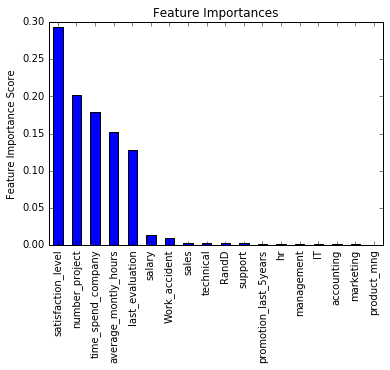

In [11]:
#baseline model (default parameters)

gbm0 = RandomForestClassifier(random_state=10) # default parameters, gini by dedault 
X_train,Y_train=modelfit(gbm0,datos)

In [16]:
#tuning paramaters with K-folds
#fijamos el número de árboles en 50
# ajustamos "max_depth" y el número mínimo en cada hoja.

param_test1 ={'min_weight_fraction_leaf':[0,0.02,0.04,0.06,.08],'max_depth':[6,7,8,9,10]} # probamos 20,30,40...80 árboles 

min_samples_split=int(np.round(len(X_train)*.005)) # del .5 al 1% del número de observaciones 
min_samples_leaf=datos.left.sum()/len(datos)-.05 # fraccion de personas que han renunciado menos 5% 

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=50,min_samples_split=min_samples_split
,max_features='sqrt',random_state=10)
,param_grid = param_test1, scoring='recall',n_jobs=-1,iid=False,cv=5)

#Y_train=np.array(Y_train)
#c, r = Y_train.shape
#Y_train = Y_train.reshape(c,)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.89657, std: 0.01929, params: {'min_weight_fraction_leaf': 0, 'max_depth': 6},
  mean: 0.88592, std: 0.01798, params: {'min_weight_fraction_leaf': 0.02, 'max_depth': 6},
  mean: 0.77972, std: 0.04884, params: {'min_weight_fraction_leaf': 0.04, 'max_depth': 6},
  mean: 0.68023, std: 0.02679, params: {'min_weight_fraction_leaf': 0.06, 'max_depth': 6},
  mean: 0.65694, std: 0.02559, params: {'min_weight_fraction_leaf': 0.08, 'max_depth': 6},
  mean: 0.90683, std: 0.01227, params: {'min_weight_fraction_leaf': 0, 'max_depth': 7},
  mean: 0.88039, std: 0.02370, params: {'min_weight_fraction_leaf': 0.02, 'max_depth': 7},
  mean: 0.77890, std: 0.02811, params: {'min_weight_fraction_leaf': 0.04, 'max_depth': 7},
  mean: 0.69445, std: 0.03304, params: {'min_weight_fraction_leaf': 0.06, 'max_depth': 7},
  mean: 0.66247, std: 0.01991, params: {'min_weight_fraction_leaf': 0.08, 'max_depth': 7},
  mean: 0.91275, std: 0.01112, params: {'min_weight_fraction_leaf': 0, 'max_depth': 8},
  mean: 

In [19]:
#tuning paramaters with K-folds

#fijamos "min_weight_fraction_leaf"=0 y ampliamos la búsqueda de la profundidad 
# ajustamos el número mínimo de muestras en nodo para split

param_test2 = {'min_samples_split':[45,52,63,73,84,94,105],'max_depth':[10,11,12]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=50, max_features='sqrt'
,min_weight_fraction_leaf=0, random_state=10), param_grid = param_test2, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.91670, std: 0.01398, params: {'min_samples_split': 45, 'max_depth': 10},
  mean: 0.91591, std: 0.01481, params: {'min_samples_split': 52, 'max_depth': 10},
  mean: 0.91630, std: 0.01220, params: {'min_samples_split': 63, 'max_depth': 10},
  mean: 0.91512, std: 0.01430, params: {'min_samples_split': 73, 'max_depth': 10},
  mean: 0.91472, std: 0.01403, params: {'min_samples_split': 84, 'max_depth': 10},
  mean: 0.91275, std: 0.01484, params: {'min_samples_split': 94, 'max_depth': 10},
  mean: 0.91354, std: 0.01490, params: {'min_samples_split': 105, 'max_depth': 10},
  mean: 0.91512, std: 0.01197, params: {'min_samples_split': 45, 'max_depth': 11},
  mean: 0.91551, std: 0.01307, params: {'min_samples_split': 52, 'max_depth': 11},
  mean: 0.91354, std: 0.01214, params: {'min_samples_split': 63, 'max_depth': 11},
  mean: 0.91236, std: 0.01313, params: {'min_samples_split': 73, 'max_depth': 11},
  mean: 0.91433, std: 0.01433, params: {'min_samples_split': 84, 'max_depth': 11},
  m

In [21]:
#tuning paramaters with K-folds

#fijamos la profundidad en 12, y extendemos búsqueda de número mínimo para split 


param_test3 = {'max_features':[6,7,8,9,10],'min_samples_split':[5,10,20,35]}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=50,max_depth=12
,min_weight_fraction_leaf=0,random_state=10), param_grid = param_test3, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.92815, std: 0.01510, params: {'min_samples_split': 5, 'max_features': 6},
  mean: 0.92104, std: 0.01285, params: {'min_samples_split': 10, 'max_features': 6},
  mean: 0.92025, std: 0.01266, params: {'min_samples_split': 20, 'max_features': 6},
  mean: 0.91828, std: 0.01366, params: {'min_samples_split': 35, 'max_features': 6},
  mean: 0.93130, std: 0.01415, params: {'min_samples_split': 5, 'max_features': 7},
  mean: 0.92262, std: 0.01398, params: {'min_samples_split': 10, 'max_features': 7},
  mean: 0.91986, std: 0.01348, params: {'min_samples_split': 20, 'max_features': 7},
  mean: 0.92025, std: 0.01302, params: {'min_samples_split': 35, 'max_features': 7},
  mean: 0.93289, std: 0.01444, params: {'min_samples_split': 5, 'max_features': 8},
  mean: 0.92420, std: 0.01329, params: {'min_samples_split': 10, 'max_features': 8},
  mean: 0.91986, std: 0.01307, params: {'min_samples_split': 20, 'max_features': 8},
  mean: 0.92025, std: 0.01359, params: {'min_samples_split': 35, 'ma

In [22]:
#tuning paramaters with K-folds

#fijamos el número máximo de variables en 8 y el número mínimo para split en 5.

param_test4 = {'criterion':('gini','entropy')}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=50,max_depth=12,max_features=8
,min_weight_fraction_leaf=0,min_samples_split=5, random_state=10), param_grid = param_test4, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.93289, std: 0.01444, params: {'criterion': 'gini'},
  mean: 0.93130, std: 0.01505, params: {'criterion': 'entropy'}],
 {'criterion': 'gini'},
 0.93288584325373625)

C:\Users\Edu\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Model Report
Training Recall : 0.9641
CV Recall Score : Mean - 0.9328858 | Std - 0.0144406 | Min - 0.9151874 | Max - 0.9585799


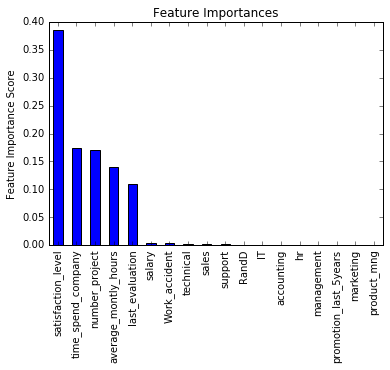

In [23]:
#Let’s fit the model again on this and have a look at the feature importance.
x_train,y_train=modelfit(gsearch4.best_estimator_,datos)

In [24]:
def modelfit1(algorithm,datos, performCV=True, printFeatureImportance=True, cv_folds=5): #5 "pliegues" para CV
    
    #separar "x,y"
    Y=datos.iloc[:,6:7]
    X=datos.ix[:, datos.columns != 'left']
    
    #separar datos de entrenamiento y prueba
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    Y_train=np.array(Y_train)
            
    #Fit the algorithm on the training data
    algorithm.fit(X_train,Y_train)
        
    #Predict test set:
    dtest_predictions = algorithm.predict(X_test)
    dtest_predprob = algorithm.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        c, r = Y_train.shape
        Y_train = Y_train.reshape(c,)
        cv_scoreR = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='recall',n_jobs=-1,cv=5)
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    #Print model report:
    print ("\nModel Report")
    print ("Test Recall : %.4g" % metrics.recall_score(Y_test.values, dtest_predictions))
    
    if performCV:
        print ("CV Recall Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_scoreR),np.std(cv_scoreR),np.min(cv_scoreR),np.max(cv_scoreR)))
       
    #Print Feature Importance:
    if printFeatureImportance:
        predictors=list(X_train.columns.values)
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return X_test,Y_test

C:\Users\Edu\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Model Report
Test Recall : 0.9326
CV Recall Score : Mean - 0.9305151 | Std - 0.01473887 | Min - 0.9171598 | Max - 0.9585799


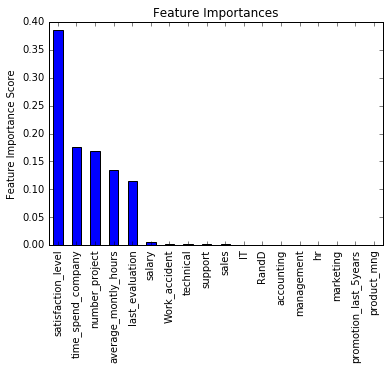

In [29]:
# ya que tenemos ajustados todos los parámetros, aumentamos el número de árboles 

gbm_tuned = RandomForestClassifier(n_estimators=150,max_depth=12,min_samples_split=5,criterion='gini'
,min_weight_fraction_leaf=0, random_state=10, max_features=8)

X_test,Y_test=modelfit1(gbm_tuned,datos)

C:\Users\Edu\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Model Report
Test Recall : 0.9586
CV Recall Score : Mean - 0.9510466 | Std - 0.01545007 | Min - 0.9368836 | Max - 0.9783037


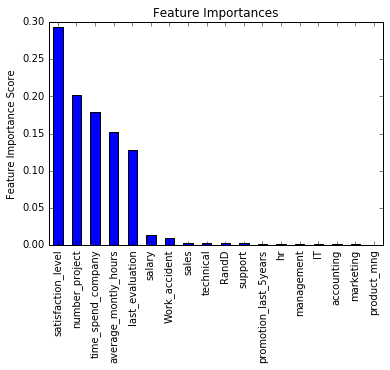

In [26]:
#modelo con parámetros default 
X_test,Y_test=modelfit1(gbm0,datos)